In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
# mo hinh
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc


# tien xu ly
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
import joblib
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS


In [61]:
df = pd.read_csv("/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv")
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [62]:
df['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

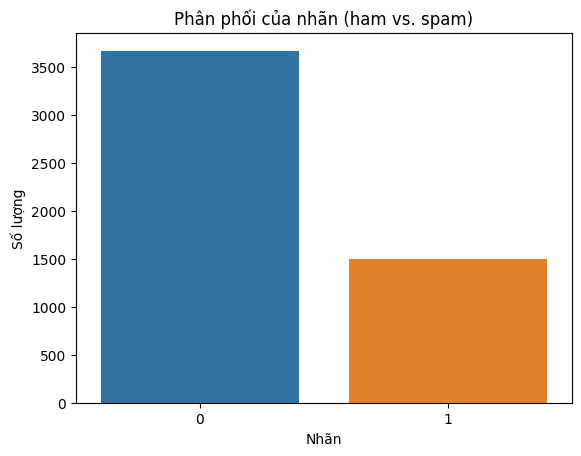

In [63]:
sns.countplot(x='label_num', data=df)
plt.title("Phân phối của nhãn (ham vs. spam)")
plt.xlabel("Nhãn")
plt.ylabel("Số lượng")
plt.show()

In [64]:
df['text'] = df['text'].str.replace('subject', '')

In [65]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [66]:
stop = set(stopwords.words('english'))

In [67]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
     
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

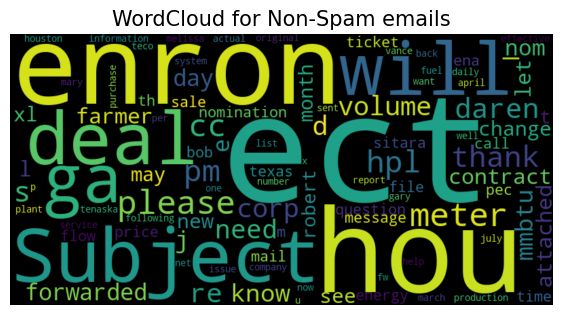

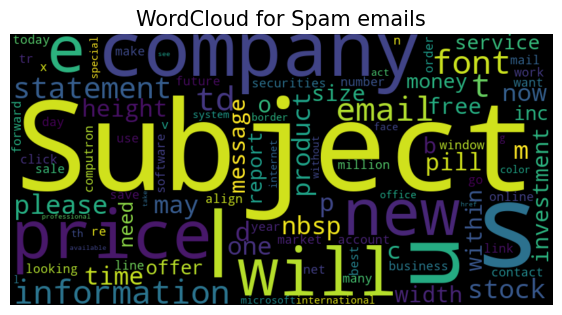

In [68]:
plot_word_cloud(df[df['label_num'] == 0], typ='Non-Spam')
plot_word_cloud(df[df['label_num'] == 1], typ='Spam')

In [69]:
def clean_text(text):
    text=text.lower()
    text=re.sub('[^a-zA-Z]', ' ', text)
    text=text.split()
    text = [word for word in text if word not in stop]
    text=' '.join(text)
    return text

In [70]:
df['text'] = df['text'].apply(clean_text)

In [71]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,subject enron methanol meter follow note gave ...,0
1,2349,ham,subject hpl nom january see attached file hpln...,0
2,3624,ham,subject neon retreat ho ho ho around wonderful...,0
3,4685,spam,subject photoshop windows office cheap main tr...,1
4,2030,ham,subject indian springs deal book teco pvr reve...,0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [73]:
df.dtypes

Unnamed: 0     int64
label         object
text          object
label_num      int64
dtype: object

In [74]:
df.describe()

,Unnamed: 0,label_num
count,5171.000000,5171.000000
mean,2585.000000,0.289886
std,1492.883452,0.453753
min,0.000000,0.000000
25%,1292.500000,0.000000
50%,2585.000000,0.000000
75%,3877.500000,1.000000
max,5170.000000,1.000000


In [75]:
df.nunique()

Unnamed: 0    5171
label            2
text          4630
label_num        2
dtype: int64

In [76]:
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [77]:
df.duplicated().sum()

0

In [78]:
df = df.drop_duplicates()

In [79]:
df.duplicated().sum()

0

## tfidf

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

### TF-IDF (Term Frequency-Inverse Document Frequency) là một kỹ thuật phổ biến trong xử lý ngôn ngữ tự nhiên (NLP) và khai phá văn bản, được sử dụng để biểu diễn văn bản dưới dạng vector số. 

### Mục tiêu của TF-IDF là xác định mức độ quan trọng của một từ trong một văn bản cụ thể trong tập hợp các văn bản.

# TF là gì
TF = số lần từ xuát hiện trong văn bản / tổng số từ trong văn bản


Ví dụ: Nếu từ "spam" xuất hiện 3 lần trong một email có tổng cộng 100 từ, thì TF của "spam" sẽ là 3/100=0.03

# IDF  Tần suất nghịch đảo của văn bản
### IDF đo lường mức độ phổ biến của một từ trong toàn bộ tập văn bản.

### IDF = log(Tổng số văn bản/Số văn bản chứa từ đó)
### Ví dụ: Nếu từ "email" xuất hiện trong hầu hết các văn bản, thì IDF của từ này sẽ thấp. Ngược lại, nếu từ "phishing" chỉ xuất hiện trong một số ít văn bản, IDF sẽ cao.

# Công thức TF-IDF  giúp đánh giá mức độ quan trọng của một từ trong một văn bản
### Từ nào xuất hiện thường xuyên trong văn bản (TF cao).
### Từ nào ít phổ biến trong toàn bộ tập văn bản (IDF cao)

# TF-IDF = TF*IDF

# Ứng dụng
### Phân loại văn bản: Như phân loại email spam và ham.
### Trích xuất từ khóa: Tìm ra các từ khóa quan trọng trong một tài liệu.
### Tìm kiếm văn bản: TF-IDF giúp đánh giá mức độ liên quan của một tài liệu với truy vấn tìm kiếm.

In [81]:
# xoa cot dau
# df.head()
df = df.drop(df.columns[0], axis=1)
df = df.drop(df.columns[0], axis=1)
df.head()

,text,label_num
0,subject enron methanol meter follow note gave ...,0
1,subject hpl nom january see attached file hpln...,0
2,subject neon retreat ho ho ho around wonderful...,0
3,subject photoshop windows office cheap main tr...,1
4,subject indian springs deal book teco pvr reve...,0


# Chuẩn bị dữ liệu

In [82]:
X_text = df['text']
y = df['label_num']

X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test_text).toarray()

In [83]:
def feature(model, tfidf_vectorizer):
    importance = model.feature_importances_
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # sap xep theo do quan trong 
    # chi hien thi 20 dac trung quan trong
    indices = np.argsort(importance)[-20:] 
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importance[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Dac trung quan trong")
    plt.title("Top 20 Feature")
    plt.show()

In [84]:
def confusion_matrix(model, X_test_tfidf, y_test):
    ConfusionMatrixDisplay.from_estimator(model, X_test_tfidf, y_test)
    plt.title("Confusion Matrix")
    plt.show()

In [85]:
def roc_acc_line(X_test_tfidf, y_test, y_pred_prob):
    y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1]
    
    # tinh ROC 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Decision Tree


In [86]:
model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)
model.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [87]:
# danh gia
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Độ chính xác của mô hình: 0.78

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.70      0.82       735
           1       0.57      0.99      0.72       300

    accuracy                           0.78      1035
   macro avg       0.78      0.84      0.77      1035
weighted avg       0.87      0.78      0.79      1035



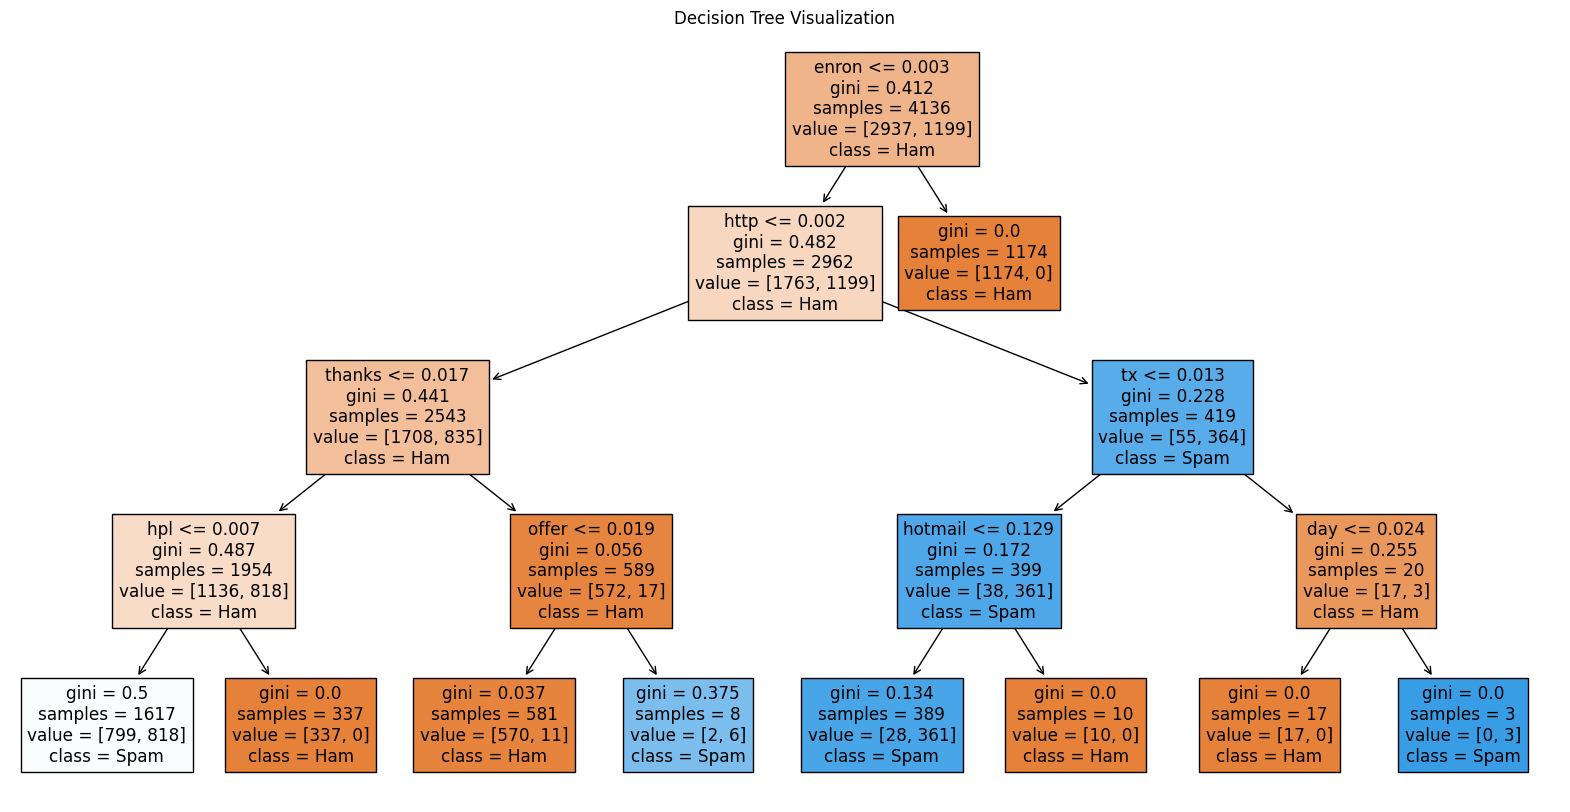

In [88]:
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=tfidf_vectorizer.get_feature_names_out(), class_names=['Ham', 'Spam'])
plt.title("Decision Tree Visualization")
plt.show()


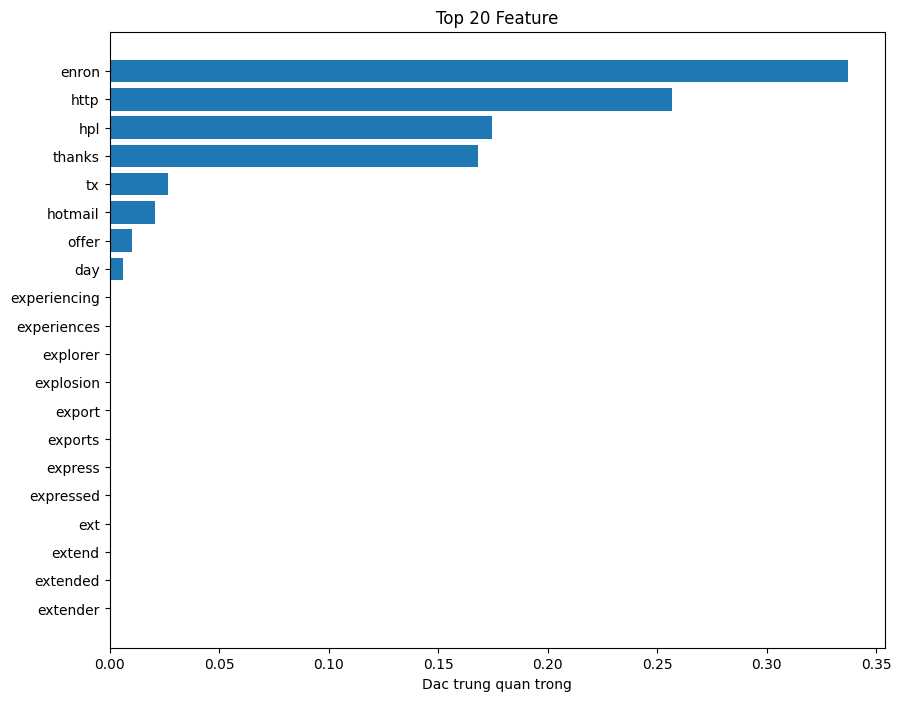

In [89]:
feature(model, tfidf_vectorizer)

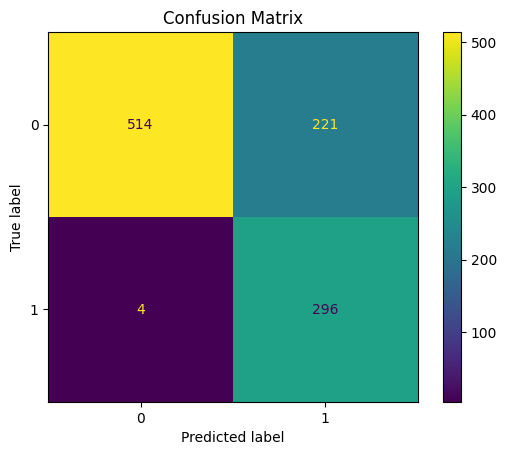

In [90]:
confusion_matrix(model, X_test_tfidf, y_test)

# XGBClassifier

In [91]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [92]:
# danh gia
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Độ chính xác của mô hình: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       735
           1       0.93      0.97      0.95       300

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



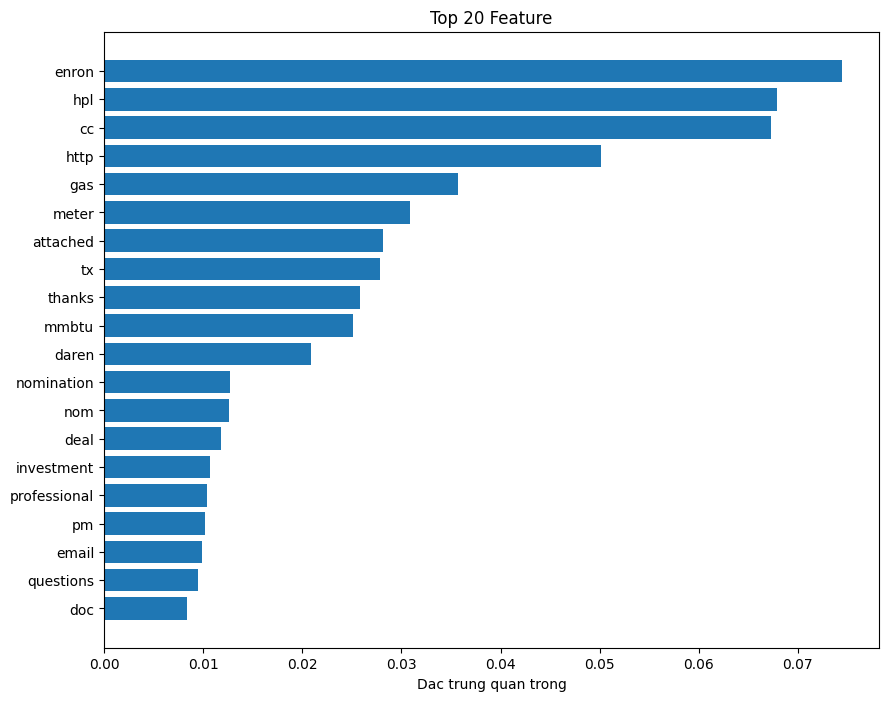

In [93]:
feature(model, tfidf_vectorizer)

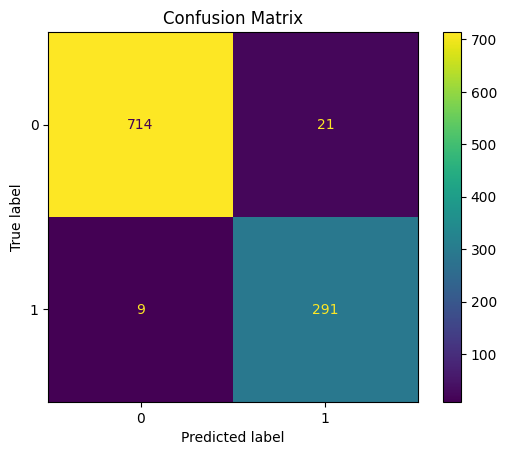

In [94]:
confusion_matrix(model, X_test_tfidf, y_test)

# RandomForestClassifier

In [95]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [96]:
# danh gia
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình Random Forest: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Độ chính xác của mô hình Random Forest: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       735
           1       0.94      0.99      0.96       300

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.97      1035
weighted avg       0.98      0.98      0.98      1035



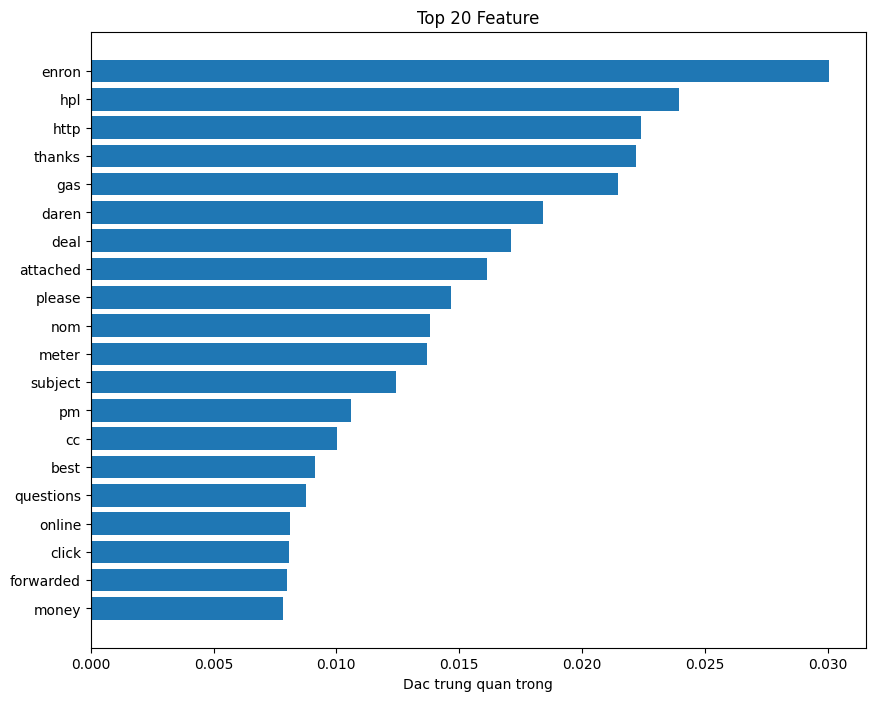

In [97]:
feature(model, tfidf_vectorizer)

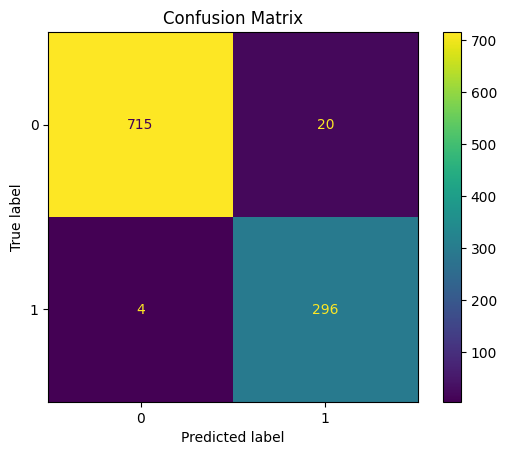

In [98]:
confusion_matrix(model, X_test_tfidf, y_test)

# AdaBoostClassifier

In [99]:
# mo hinh co so la decisiontree voi do sau nong 1 de quyet dinh co phan ngau nhien
base_estimator = DecisionTreeClassifier(max_depth=1)  
model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, random_state=42)
model.fit(X_train_tfidf, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

In [100]:
# danh gia
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình AdaBoost: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Độ chính xác của mô hình AdaBoost: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       735
           1       0.92      0.95      0.93       300

    accuracy                           0.96      1035
   macro avg       0.95      0.96      0.95      1035
weighted avg       0.96      0.96      0.96      1035



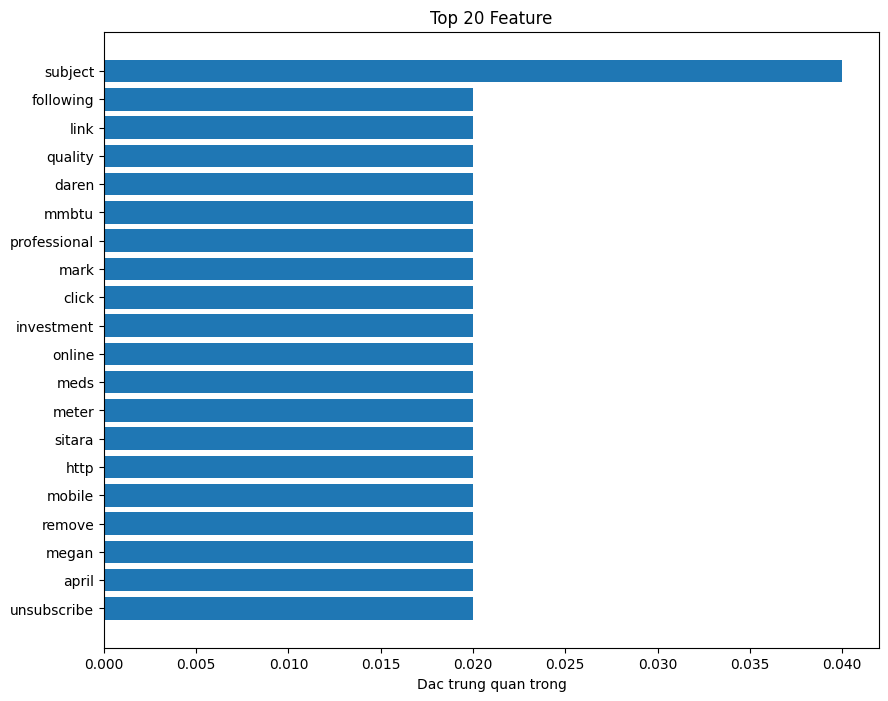

In [101]:
feature(model, tfidf_vectorizer)

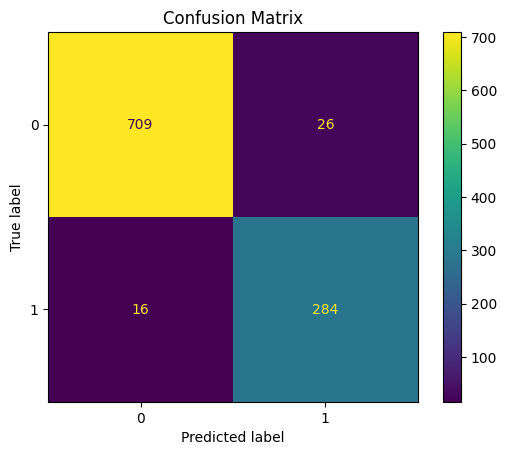

In [102]:
confusion_matrix(model, X_test_tfidf, y_test)

# KNeighborsClassifier

In [103]:
model = KNeighborsClassifier(n_neighbors=5, metric='cosine')
model.fit(X_train_tfidf, y_train)

KNeighborsClassifier(metric='cosine')

In [104]:
# danh gia
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình KNN: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Độ chính xác của mô hình KNN: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       735
           1       0.95      0.92      0.94       300

    accuracy                           0.96      1035
   macro avg       0.96      0.95      0.95      1035
weighted avg       0.96      0.96      0.96      1035



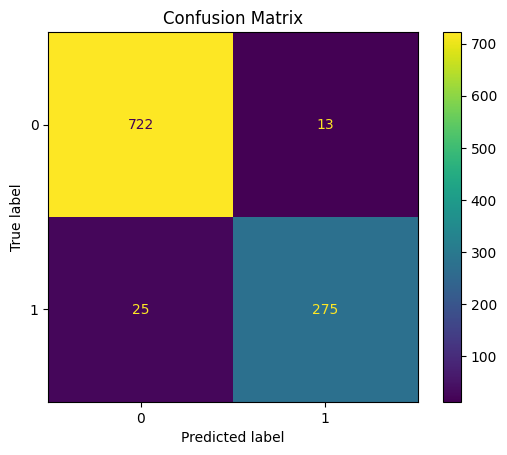

In [105]:
confusion_matrix(model, X_test_tfidf, y_test)

# GradientBoostingClassifier

In [106]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_tfidf, y_train)

GradientBoostingClassifier(random_state=42)

In [107]:
# danh gia
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình Gradient Boosting: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Độ chính xác của mô hình Gradient Boosting: 0.95

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       735
           1       0.92      0.92      0.92       300

    accuracy                           0.95      1035
   macro avg       0.94      0.94      0.94      1035
weighted avg       0.95      0.95      0.95      1035



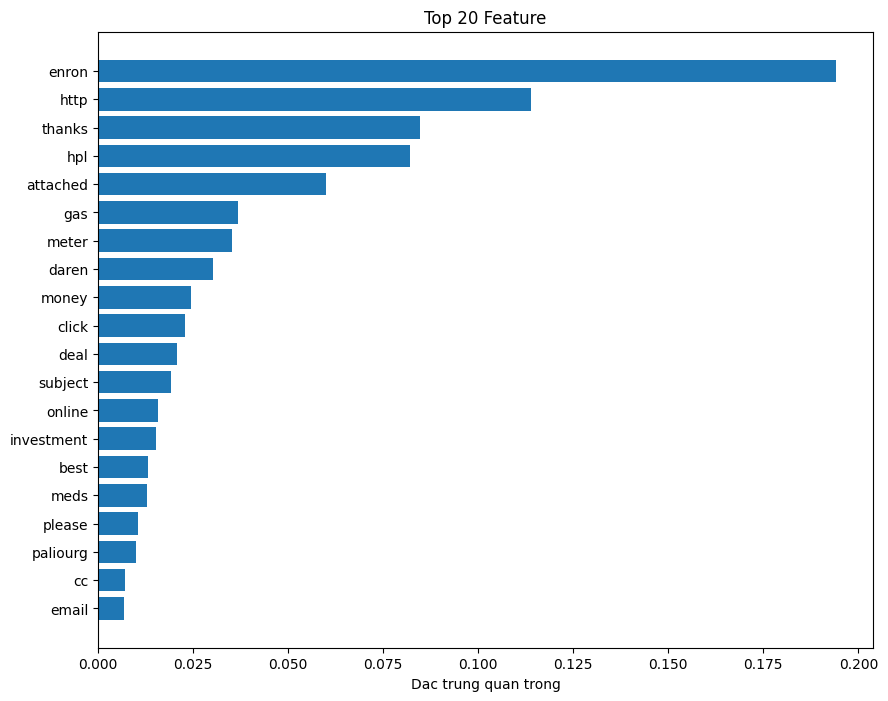

In [108]:
feature(model, tfidf_vectorizer)

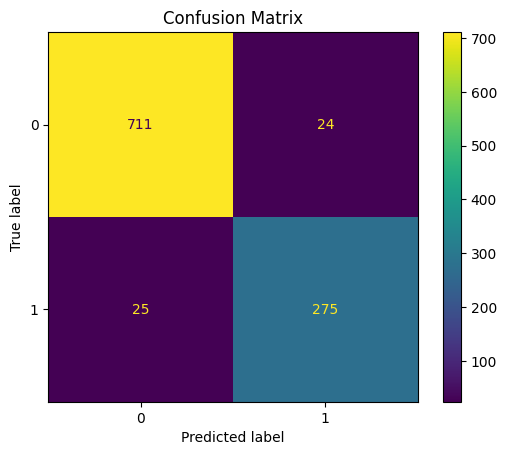

In [109]:
confusion_matrix(model, X_test_tfidf, y_test)

# StackingClassifier

In [110]:
# tao mo hinh hoc yeu 
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

estimators = [
    ('decision_tree', decision_tree),
    ('knn', knn),
    ('logistic_regression', logistic_regression)
]

# mo hinh meta la RandomForest
stacking_model = StackingClassifier(estimators=estimators, 
                                    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42))
stacking_model.fit(X_train_tfidf, y_train)

y_pred = stacking_model.predict(X_test_tfidf)

In [111]:
# danh gia
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình Stacking Ensemble: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Độ chính xác của mô hình Stacking Ensemble: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       735
           1       0.97      0.96      0.96       300

    accuracy                           0.98      1035
   macro avg       0.98      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



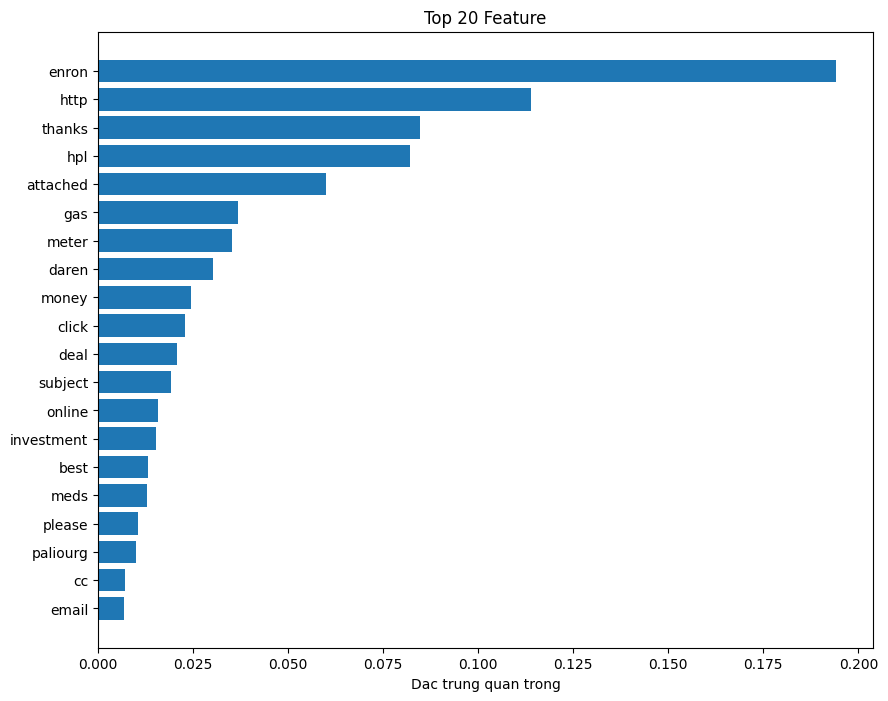

In [112]:
feature(model, tfidf_vectorizer)

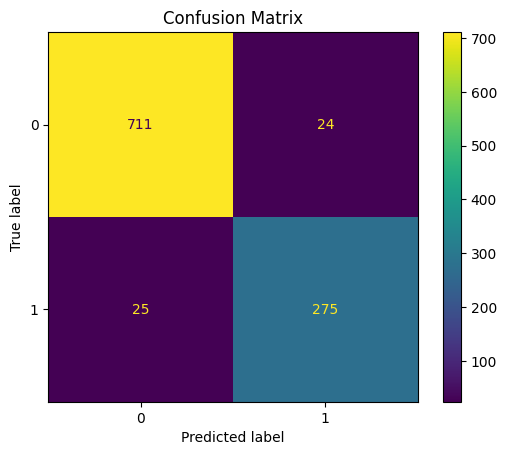

In [113]:
confusion_matrix(model, X_test_tfidf, y_test)

# Voting model

In [114]:
logistic = LogisticRegression(max_iter=1000, random_state=42)
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

# khoi tao VotingClassifier
voting_model = VotingClassifier(estimators=[
    ('logistic', logistic),
    ('decision_tree', decision_tree),
    ('knn', knn)
], voting='hard')

voting_model.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('decision_tree',
                              DecisionTreeClassifier(max_depth=3,
                                                     random_state=42)),
                             ('knn', KNeighborsClassifier())])

In [115]:
# danh gia
y_pred = voting_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của Voting Classifier: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Độ chính xác của Voting Classifier: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       735
           1       0.97      0.93      0.95       300

    accuracy                           0.97      1035
   macro avg       0.97      0.96      0.97      1035
weighted avg       0.97      0.97      0.97      1035



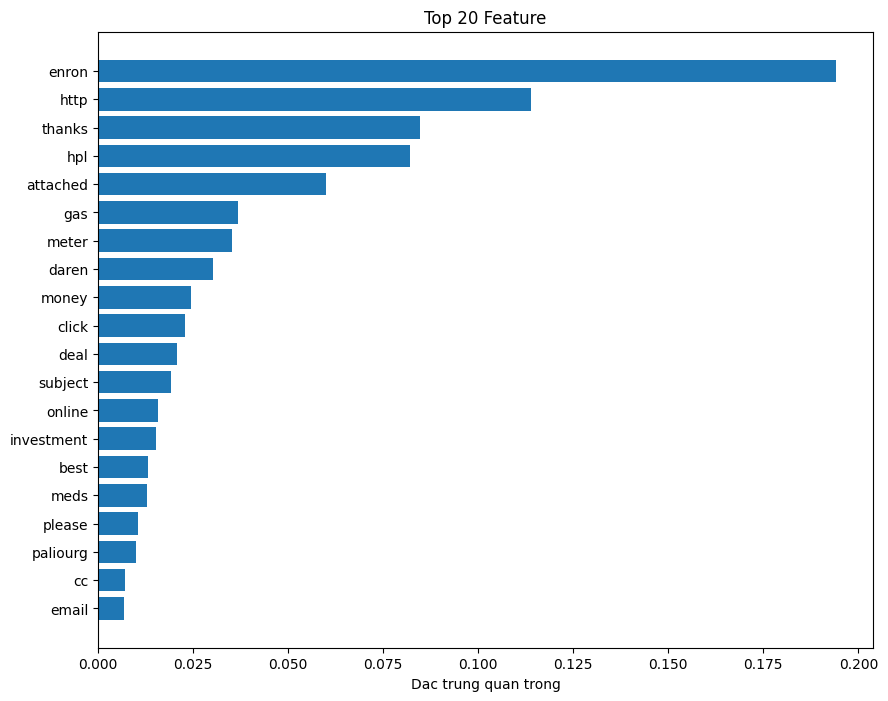

In [116]:

feature(model, tfidf_vectorizer)

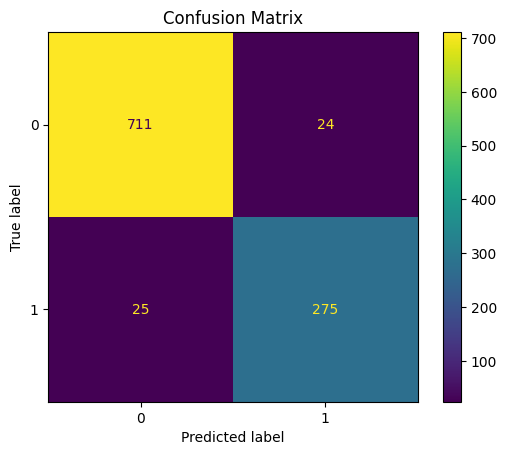

In [117]:
confusion_matrix(model, X_test_tfidf, y_test)